In [1]:
import faiss
import numpy as np
import json
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import matplotlib.pyplot as plt

c:\Users\nicol\Documents\ESILV\S9\LLM and GenAI\Projet\python_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jobs_index = faiss.read_index("./data/jobs_index.faiss")
with open("./data/jobs_index_mapping.json", "r") as f:
    jobs_mapping = {int(k): v for k, v in json.load(f).items()}

resume_index = faiss.read_index("./data/resume_index.faiss")
with open("./data/resume_index_mapping.json", "r") as f:
    resume_mapping = json.load(f)

model = SentenceTransformer("all-MiniLM-L6-v2")

def find_top_jobs(cv_text, top_n=5):
    cv_emb = model.encode([cv_text], convert_to_numpy=True)
    cv_emb /= np.linalg.norm(cv_emb, axis=1, keepdims=True)
    distances, indices = jobs_index.search(cv_emb, top_n)
    return [{"job_id": jobs_mapping.get(idx, f"Unknown_{idx}"), "score": float(score)}
            for score, idx in zip(distances[0], indices[0])]

def reconstruct_embeddings(index):
    embeddings = np.zeros((index.ntotal, index.d), dtype=np.float32)
    for i in range(index.ntotal):
        index.reconstruct(i, embeddings[i])
    return embeddings

In [3]:
cv_embeddings = reconstruct_embeddings(resume_index)
job_embeddings = reconstruct_embeddings(jobs_index)
all_embeddings = np.vstack([cv_embeddings, job_embeddings])

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_2d = reducer.fit_transform(all_embeddings)

cv_2d, job_2d = all_2d[:len(cv_embeddings)], all_2d[len(cv_embeddings):]

cv_index = 0
cv_emb_normalized = cv_embeddings[cv_index:cv_index+1] / np.linalg.norm(cv_embeddings[cv_index:cv_index+1], axis=1, keepdims=True)
distances, indices = jobs_index.search(cv_emb_normalized, 5)
results = [{"job_id": jobs_mapping[idx], "score": float(score)} for score, idx in zip(distances[0], indices[0])]
print(f"Top 5 jobs for CV {resume_mapping[cv_index]}:")
for r in results:
    print(r)

c:\Users\nicol\Documents\ESILV\S9\LLM and GenAI\Projet\python_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


MemoryError: Unable to allocate 4.41 GiB for an array with shape (705236, 839) and data type float64

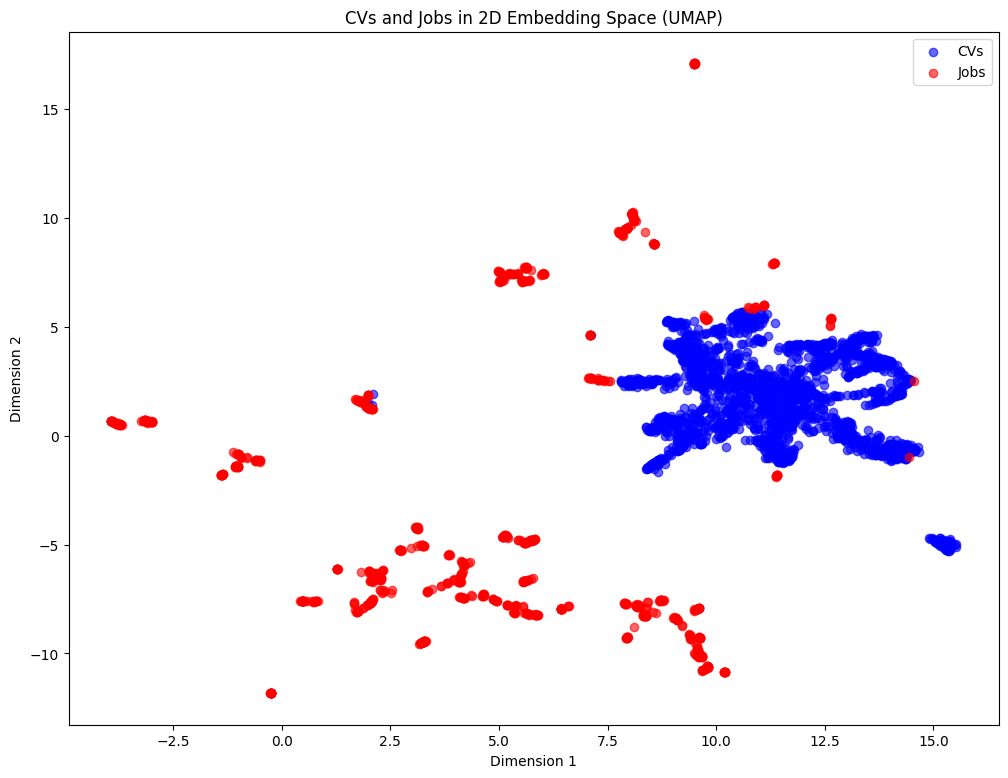

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(cv_2d[:, 0], cv_2d[:, 1], c="blue", label="CVs", alpha=0.6)
plt.scatter(job_2d[:, 0], job_2d[:, 1], c="red", label="Jobs", alpha=0.6)
plt.legend()
plt.title("CVs and Jobs in 2D Embedding Space (UMAP)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()